# _HÉCTOR J. APARICIO MUÑOZ_

# Aprendizaje con Scikit-Multiflow

In [1]:
%matplotlib notebook

## Importamos el generador del flujo de datos a utilizar y el método de evaluación:

In [2]:
from skmultiflow.data import WaveformGenerator
from skmultiflow.evaluation import EvaluatePrequential

## Pruebas de clasificadores y su evaluación.

Las siguientes funciones, `prueba_clasificador()` y `prueba_evaluacion_clasificador()`, hacen alguna prueba con un clasificador.

In [3]:
def prueba_clasificador(clasificador):
    """
    Algunas pruebas iniciales de un clasificador.
    """

    generator = WaveformGenerator()

    X, y = generator.next_sample(10)
    print("Etiquetas:", y)
    clasificador.fit(X,y)
    
    X, y = generator.next_sample(10)
    print("Predicciones en bloque:", y, clasificador.predict(X), "\n", clasificador.predict_proba(X))

    print("Predicciones una a una:")
    for i in range(10):
        X, y = generator.next_sample()
        print(y, clasificador.predict(X), clasificador.predict_proba(X))
        clasificador.partial_fit(X, y)

In [4]:
def prueba_evaluacion_clasificador(clasificador):
    """
    Prueba inicial de la evaluación de un clasificador
    """
    
    stream = WaveformGenerator() 

    evaluator = EvaluatePrequential(show_plot=True, max_samples=10000,
        metrics=['accuracy', 'kappa', 'kappa_t', 'kappa_m'])

    evaluator.evaluate(stream=stream, model=clasificador)

# *--> Clasificador por clase previa*

Se implementa el *clasisificador de clase previa*, que predice la etiqueta de la última instancia etiquetada recibida.

La clase se llamará `NoChangeClassifier` y debe heredar de `BaseSKMObject` y `ClassifierMixin`.

Como referencia, se puede consultar el código de alguno de los clasificadores incluidos en sckit-multiflow, como https://github.com/scikit-multiflow/scikit-multiflow/blob/d073a70/src/skmultiflow/bayes/naive_bayes.py#L12

In [5]:
# NOTA: Cualquier modelo sobre flujos se crea extendiendo la clase base BaseSKMObject y alguno de los mixins para 
# las correspondientes tareas: ClassifierMixin, RegressorMixin, MetaEstimatorMixin, MultiOutputMixin.
# Para los siguientes casos el mixin utilizado será ClassifierMixin. En ese mixin se describe de forma general 
# cada uno de los métodos por defecto que tendrán los clasificadores que de él hereden:
#    Método fit (que llama a partial_fit) --> entrenamiento en modo batch.
#    Método partial_fit --> entrenamiento incremental.
#    Método predict --> predicción del valor objetivo en métodos supervisados.
#    Método predict_proba --> probabilidad para cada clase en problemas de clasificación.

In [6]:
# NOTA: En todos los clasificadores que voy a crear a continuación seguiré lo más fielmente el modelo consultado 
# como referencia y los métodos de ClassifierMixin, incluyendo sus parámetros classes y sample_weight, aunque 
# para algunos de estos clasificadores no sean necesarios.

In [7]:
# Clase NoChangeClassifier

import numpy as np

from skmultiflow.utils import get_dimensions  # Utilizado para obtener las dimensiones de un array dentro del 
                                              # código del clasificador.
from skmultiflow.core.base import BaseSKMObject, ClassifierMixin # Superclases de las que heredará el clasificador.


class NoChangeClassifier(BaseSKMObject, ClassifierMixin):
    """
    Clasificador que predice la etiqueta de la última instancia recibida para entrenar
    """
    
    def __init__(self):
        super().__init__()  # Para heredar de las superclases.
        self._observed_class_distribution = {}  # Diccionario donde almacenaré los diferentes valores de la clase 
                                                # que van llegando y el número de veces que lo hacen, ponderado 
                                                # con el peso de cada instancia correspondiente, en el caso de 
                                                # que se indiquen dichos pesos.
        self._classes = None  # Para algún método de clasificación puede ser necesario que se le indiquen como 
                              # parámetro las diferentes clases que le van a llegar en las instancias.
        self._clase_prev = None  # Atributo en el que almacenaré la clase de la instancia previa.
    
    def partial_fit(self, X, y, classes=None, sample_weight=None):
        """ Partially (incrementally) fit the model.
        
        Parameters
        ----------
        X : numpy.ndarray of shape (n_samples, n_features)
            The features to train the model.
        
        y: numpy.ndarray of shape (n_samples)
            An array-like with the labels of all samples in X.
        
        classes: numpy.ndarray, optional (default=None)
            Array with all possible/known classes. Usage varies depending on the learning method.
        
        sample_weight: numpy.ndarray of shape (n_samples), optional (default=None)
            Samples weight. If not provided, uniform weights are assumed.
            Usage varies depending on the learning method.
        
        Returns
        -------
        Clasificador clase previa
            self
        
        """
        if not self._classes and classes is not None:
            self._classes = classes

        if y is not None:
            row_cnt, _ = get_dimensions(X) # Como lo que me interesa es el número de filas de X, podría haber 
                                           # utilizado row_cnt = X.shape[0], o bien row_cnt = len(X)
            if sample_weight is None:
                sample_weight = np.ones(row_cnt)
            if row_cnt != len(sample_weight):
                raise ValueError(
                    'Inconsistent number of instances ({}) and weights ({}).'.format(row_cnt, len(
                        sample_weight)))
            for i in range(row_cnt):
                if sample_weight[i] != 0.0:
                    self._partial_fit(X[i], y[i], sample_weight[i])
        return self
    
    def _partial_fit(self, X, y, weight):  # Utilizo este método privado para entrenar el modelo con 
                                           # muestras que le llegan de una en una.
        """ Trains the model on samples X and corresponding targets y.
        
        Private function where actual training is carried on.
        
        Parameters
        ----------
        X: numpy.ndarray of shape (1, n_features)
            Instance attributes.
        y: int
            Class label for sample X.
        sample_weight: float
            Sample weight.
        
        """
        try:
            self._observed_class_distribution[y] += weight
        except KeyError:
            self._observed_class_distribution[y] = weight
        # NOTA: Para este clasificador por clase previa no es necesario tener en cuenta los pesos de la instancia 
        # correspondiente, pero lo mantengo aquí por lo que dije antes, por seguir lo más fielmente el modelo 
        # de referencia consultado y los métodos de ClassifierMixin.
        
        self._clase_prev = y  # El entrenamiento de este modelo es tan simple como quedarnos con el valor de 
                              # la clase de la instancia previa.
    
    def predict(self, X):
        """ Predict classes for the passed data.
        
        Parameters
        ----------
        X : numpy.ndarray of shape (n_samples, n_features)
            The set of data samples to predict the labels for.
        
        Returns
        -------
        A numpy.ndarray with all the predictions for the samples in X.
        
        """
        # NOTA: En este clasificador por clase previa, siempre que hagamos predicciones en bloque, va a devolver 
        # el mismo valor para todas las instancias recibidas en el bloque, que se corresponderá con la clase 
        # de la última instancia con la que se ha entrenado el modelo.
        # NOTA: Si hacemos predicciones una a una, y después de cada predicción usamos esa instancia para 
        # entrenar el modelo, entonces sí devuelve la clase previa cada vez.
        
        lista_pred = []  # Lista que usaré para almacenar las predicciones de las instancias recibidas.
        for i in range(len(X)):
            lista_pred.append(self._clase_prev)
        return np.array(lista_pred)  # Devolvemos un array de Numpy.
    
    def predict_proba(self, X):
        """ Estimates the probability of each sample in X belonging to each of the class-labels.
        
        Parameters
        ----------
        X : Numpy.ndarray of shape (n_samples, n_features)
            The matrix of samples one wants to predict the class probabilities for.
        
        Returns
        -------
        A numpy.ndarray of shape (n_samples, n_labels), in which each outer entry is associated
        with the X entry of the same index. And where the list in index [i] contains
        len(self.target_values) elements, each of which represents the probability that
        the i-th sample of X belongs to a certain class-label.
        
        """
        lista_proba = []  # Lista que usaré para almacenar los arrays con las probabilidades, para cada una de 
                          # las instancias, de cada una de las clases que hasta la fecha han aparecido.
        for i in range(len(X)):
            # Vamos a necesitar conocer cuál es el máximo número de clases que hasta la fecha son conocidas en 
            # el flujo para calcular la probabilidad de cada una para cada instancia. Ese número de clases será 
            # el máximo valor entre el número de clases observadas hasta el momento y el máximo valor de clase 
            # obtenido hasta la fecha más 1.
            # NOTA: Esto es así porque las clases llegan como valores numéricos consecutivos desde el 0 al que 
            # corresponda.
            # NOTA: Ejemplo: puede pasar que en las instancias que llegan en X las clases que han aparecido sean 
            # solamente 0 y 2. En este caso el máximo número de clases que hasta la fecha han aparecido es dos, 
            # pero como las clases hemos dicho que son valores numéricos consecutivos sabemos que al ser el mayor 
            # valor de clase aparecido el 2, tenemos hasta el momento tres clases (2+1), que son 0, 1, 2.
            
            # NOTA: En el caso de que nos indiquen como parámetro las clases que tiene el flujo de instancias, 
            # el máximo número de clases será la mayor de las instancias más 1, ya que como ya hemos dicho las 
            # clases llegan como valores numéricos consecutivos empezando en 0.
            
            if self._classes is not None:
                lista_proba.append(np.zeros(int(max(self._classes)) + 1))
            else:
                aux = [len(self._observed_class_distribution), max(self._observed_class_distribution.keys()) + 1]
                lista_proba.append(np.zeros(max(aux)))  # Creamos un array cuyo tamaño corresponda al del máximo 
                                                        # número de clases del flujo conocidas hasta la fecha, 
                                                        # para almacenar las probabilidades de las clases para 
                                                        # cada instancia.
            lista_proba[i][self._clase_prev] = 1  # La probabilidad de la clase previa será 1, y la del resto 
                                                  # de clases será 0, al tratarse de un clasificador por clase 
                                                  # previa.
        return np.array(lista_proba)  # Devolvemos un array de Numpy.


### Pruebas de `NoChangeClassifier`

In [8]:
prueba_clasificador(NoChangeClassifier())        

Etiquetas: [0 0 1 0 1 0 1 1 1 1]
Predicciones en bloque: [0 0 0 0 1 2 2 2 1 1] [1 1 1 1 1 1 1 1 1 1] 
 [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Predicciones una a una:
[1] [1] [[0. 1.]]
[2] [1] [[0. 1.]]
[0] [2] [[0. 0. 1.]]
[0] [0] [[1. 0. 0.]]
[2] [0] [[1. 0. 0.]]
[1] [2] [[0. 0. 1.]]
[2] [1] [[0. 1. 0.]]
[0] [2] [[0. 0. 1.]]
[1] [0] [[1. 0. 0.]]
[2] [1] [[0. 1. 0.]]


<IPython.core.display.Javascript object>


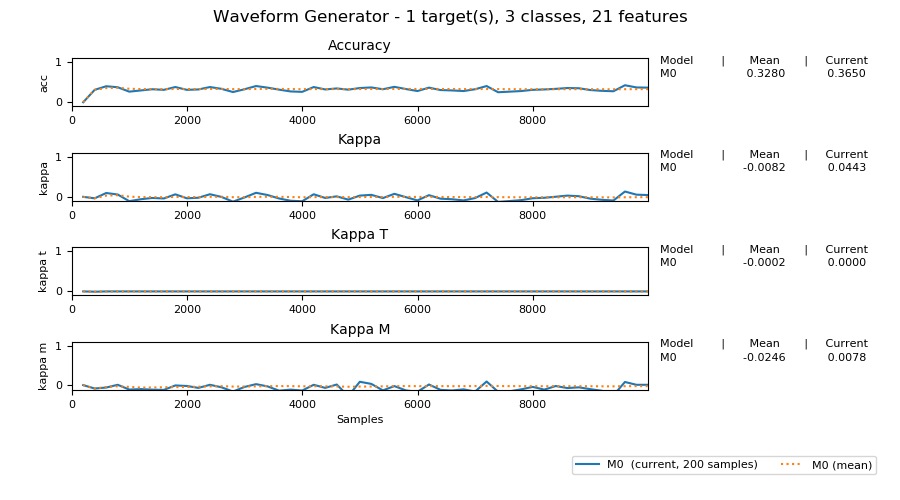

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [9.01s]
Processed samples: 10000
Mean performance:
M0 - Accuracy     : 0.3280
M0 - Kappa        : -0.0082
M0 - Kappa T      : -0.0002
M0 - Kappa M      : -0.0246


In [9]:
prueba_evaluacion_clasificador(NoChangeClassifier())    

Se pueden incluir a partir aquí pruebas adicionales.

# *--> Clasificador por clase mayoritaria*

Se implementa el clasisificador por clase mayoritaria, que predice la clase más frecuente

La clase se llamará `MajorityClassClassifier` y debe heredar de `BaseSKMObject` y `ClassifierMixin`.

El constructor tiene un argumento opcional `decay_factor`, como el que se usa en EWMA. Es un número entre 0 y 1 que indica el peso que se da a las instancias anteriores frente a la actual.

El constructor tiene otro argumento opcional `window_size`. Si se proporciona un valor debe ser un número entero e indica el tamaño de la ventana sobre la que se calcula la clase mayoritaria.

En principio se puede suponer que `decay_factor` y `window_size` no se usarán simultáneamente.

In [10]:
# Clase MajorityClassClassifier

import numpy as np

from collections import deque

from skmultiflow.utils import get_dimensions  # Utilizado para obtener las dimensiones de un array dentro del 
                                              # código del clasificador.
from skmultiflow.core.base import BaseSKMObject, ClassifierMixin # Superclases de las que heredará el clasificador.


class MajorityClassClassifier(BaseSKMObject, ClassifierMixin):
    """
    Clasificador que predice la clase más frecuente
    """

    def __init__(self, decay_factor=None, window_size=None):
        super().__init__()  # Para heredar de las superclases.
        self._observed_class_distribution = {}  # Diccionario donde almacenaré los diferentes valores de la clase 
                                                # que van llegando y el número de veces que lo hacen, ponderado 
                                                # con el peso de cada instancia correspondiente, en el caso de 
                                                # que se indiquen dichos pesos.
        self._classes = None  # Para algún método de clasificación puede ser necesario que se le indiquen como 
                              # parámetro las diferentes clases que le van a llegar en las instancias.
        self._clase_may = None  # Atributo en el que almacenaré la clase mayoritaria.
        self._ventana = deque()  # Cola de tamaño máximo window_size que utilizaré como ventana para almacenar 
                                 # las clases de las instancias cuando se proporciona un valor para el 
                                 # parámetro window_size.
        self._max_num_clases = 0  # Variable donde almacenaré el máximo número de clases distintas que sabemos 
                                  # que tiene el flujo de datos hasta el momento, en el caso en que no se indique 
                                  # el parámetro _classes.
                                  # Es necesario este atributo para que funcione correctamente el algoritmo en 
                                  # el caso de que se proporcione el parámetro window_size, para que no sucedan 
                                  # cosas como las del siguiente ejemplo: Ejemplo: suponiendo que las clases 
                                  # conocidas del flujo de datos son por ejemplo 0, 1, 2, pero en la ventana de 
                                  # tamaño window_size sólo aparecen 0 y 1, que aparezca el array con las 
                                  # probabilidades de las clases de esta forma [prob_clase_0, prob_clase_1], 
                                  # omitiendo la probabilidad de la clase 2, en lugar de que aparezca de la forma 
                                  # correcta [prob_clase_0, prob_clase_1, prob_clase_2 = 0.0].
        self.decay_factor = decay_factor
        self.window_size = window_size
        if self.window_size and type(self.window_size) is not int:
            raise ValueError("El valor del parámetro window_size debe ser un número entero.")
        if self.decay_factor and self.window_size:
            raise IOError("No pueden proporcionarse a la vez valores de decay_factor y de window_size.")
    
    def partial_fit(self, X, y, classes=None, sample_weight=None):
        """ Partially (incrementally) fit the model.
        
        Parameters
        ----------
        X : numpy.ndarray of shape (n_samples, n_features)
            The features to train the model.
        
        y: numpy.ndarray of shape (n_samples)
            An array-like with the labels of all samples in X.
        
        classes: numpy.ndarray, optional (default=None)
            Array with all possible/known classes. Usage varies depending on the learning method.
        
        sample_weight: numpy.ndarray of shape (n_samples), optional (default=None)
            Samples weight. If not provided, uniform weights are assumed.
            Usage varies depending on the learning method.
        
        Returns
        -------
        Clasificador clase mayoritaria
            self
        
        """
        if not self._classes and classes is not None:
            self._classes = classes

        if y is not None:
            row_cnt, _ = get_dimensions(X) # Como lo que me interesa es el número de filas de X, podría haber 
                                           # utilizado row_cnt = X.shape[0], o bien row_cnt = len(X)
            if sample_weight is None:
                sample_weight = np.ones(row_cnt)
            if row_cnt != len(sample_weight):
                raise ValueError(
                    'Inconsistent number of instances ({}) and weights ({}).'.format(row_cnt, len(
                        sample_weight)))
            for i in range(row_cnt):
                if sample_weight[i] != 0.0:
                    self._partial_fit(X[i], y[i], sample_weight[i])
        return self
    
    def _partial_fit(self, X, y, weight):  # Utilizo este método privado para entrenar el modelo con 
                                           # muestras que le llegan de una en una.
        """ Trains the model on samples X and corresponding targets y.
        
        Private function where actual training is carried on.
        
        Parameters
        ----------
        X: numpy.ndarray of shape (1, n_features)
            Instance attributes.
        y: int
            Class label for sample X.
        sample_weight: float
            Sample weight.
        
        """
        # En el caso de que se indiquen los pesos correspondientes de las instancias, los tiene en cuenta para 
        # calcular la clase mayoritaria ponderada.
        
        # Caso en el que se proporciona un valor para el parámetro decay_factor:
        if self.decay_factor:
            if not self._observed_class_distribution:  # Si el diccionario está vacío.
                self._observed_class_distribution[y] = self.decay_factor * weight
            else:
                if y not in self._observed_class_distribution:  # Si el diccionario no está vacío pero la clase 
                                                                # de la nueva muestra de entrenamiento no está 
                                                                # aún en el diccionario.
                    for i in self._observed_class_distribution.keys():
                        self._observed_class_distribution[i] *= (1 - self.decay_factor)
                    self._observed_class_distribution[y] = self.decay_factor * weight
                else:  # Si el diccionario no está vacío y la clase de la nueva muestra de entrenamiento sí está 
                       # ya incluída en el diccionario.
                    for j in self._observed_class_distribution.keys():
                        if j == y:
                            self._observed_class_distribution[j] *= (1 - self.decay_factor)
                            self._observed_class_distribution[j] += self.decay_factor * weight
                        else:
                            self._observed_class_distribution[j] *= (1 - self.decay_factor)
        
        # Caso en el que se proporciona un valor para el parámetro window_size:
        
        # Mantenemos una ventana de tamaño máximo window_size que contiene las clases de las instancias más 
        # recientes.
        elif self.window_size:
            if len(self._ventana) < self.window_size:
                self._ventana.append(y)
            else:
                self._ventana.popleft()
                self._ventana.append(y)
            
            self._observed_class_distribution.clear()  # Borramos los registros del diccionario 
                                                       # _observed_class_distribution, para almacenar sólo los de 
                                                       # la ventana actual.
            # Rellenamos el diccionario _observed_class_distribution con los valores de la ventana actual.
            for k in self._ventana:
                try:
                    self._observed_class_distribution[k] += weight
                except KeyError:
                    self._observed_class_distribution[k] = weight
        
        # Caso en el que no se proporcionan valores ni a decay_factor ni a window_size:
        else:
            try:
                self._observed_class_distribution[y] += weight
            except KeyError:
                self._observed_class_distribution[y] = weight
        
        self._clase_may = max(self._observed_class_distribution.items(), key=lambda x: x[1])[0] # El entrenamiento 
                                 # de este modelo es tan simple como quedarnos con el valor de clase mayoritaria 
                                 # ponderada.
    
    def predict(self, X):
        """ Predict classes for the passed data.
        
        Parameters
        ----------
        X : numpy.ndarray of shape (n_samples, n_features)
            The set of data samples to predict the labels for.
        
        Returns
        -------
        A numpy.ndarray with all the predictions for the samples in X.
        
        """
        # NOTA: En este clasificador por clase mayoritaria, siempre que hagamos predicciones en bloque, va a 
        # devolver el mismo valor para todas las instancias recibidas en el bloque, que se corresponderá con la 
        # clase mayoritaria ponderada de las instancias con las que se ha entrenado el modelo.
        # NOTA: Si hacemos predicciones una a una, y después de cada predicción usamos esa instancia para 
        # entrenar el modelo, entonces sí devuelve la clase mayoritaria ponderada cada vez.
        
        lista_pred = []  # Lista que usaré para almacenar las predicciones de las instancias recibidas.
        for i in range(len(X)):
            lista_pred.append(self._clase_may)
        return np.array(lista_pred)  # Devolvemos un array de Numpy.
    
    def predict_proba(self, X):
        """ Estimates the probability of each sample in X belonging to each of the class-labels.
        
        Parameters
        ----------
        X : Numpy.ndarray of shape (n_samples, n_features)
            The matrix of samples one wants to predict the class probabilities for.
        
        Returns
        -------
        A numpy.ndarray of shape (n_samples, n_labels), in which each outer entry is associated
        with the X entry of the same index. And where the list in index [i] contains
        len(self.target_values) elements, each of which represents the probability that
        the i-th sample of X belongs to a certain class-label.
        
        """
        lista_proba = []  # Lista que usaré para almacenar los arrays con las probabilidades, para cada una de 
                          # las instancias, de cada una de las clases que hasta la fecha han aparecido.
            
        for i in range(len(X)):
            # Vamos a necesitar conocer cuál es el máximo número de clases que hasta la fecha son conocidas en 
            # el flujo para calcular la probabilidad de cada una para cada instancia. Ese número de clases será 
            # el máximo valor entre el número de clases observadas hasta el momento y el máximo valor de clase 
            # obtenido hasta la fecha más 1.
            # NOTA: Esto es así porque las clases llegan como valores numéricos consecutivos desde el 0 al que 
            # corresponda.
            # NOTA: Ejemplo: puede pasar que en las instancias que llegan en X las clases que han aparecido sean 
            # solamente 0 y 2. En este caso el máximo número de clases que hasta la fecha han aparecido es dos, 
            # pero como las clases hemos dicho que son valores numéricos consecutivos sabemos que al ser el mayor 
            # valor de clase aparecido el 2, tenemos hasta el momento tres clases (2+1), que son 0, 1, 2.
            
            # NOTA: En el caso de que nos indiquen como parámetro las clases que tiene el flujo de instancias, 
            # el máximo número de clases será la mayor de las instancias más 1, ya que como ya hemos dicho las 
            # clases llegan como valores numéricos consecutivos empezando en 0.
            
            if self._classes is not None:
                lista_proba.append(np.zeros(int(max(self._classes)) + 1))
            else:
                aux = [len(self._observed_class_distribution), max(self._observed_class_distribution.keys()) + 1]
                if max(aux) > self._max_num_clases:
                    self._max_num_clases = max(aux)
                lista_proba.append(np.zeros(self._max_num_clases))  # Creamos un array cuyo tamaño corresponda al 
                                                        # del máximo número de clases del flujo conocidas hasta 
                                                        # la fecha, para almacenar las probabilidades de las 
                                                        # clases para cada instancia.
            sum_values = sum(self._observed_class_distribution.values())  # Suma total de instancias ponderadas.
            for key, value in self._observed_class_distribution.items():
                lista_proba[i][int(key)] = value / sum_values if sum_values != 0 else 0.0  # Se va calculando de 
                                        # esa forma la probabilidad de cada una de las clases para cada instancia.
        return np.array(lista_proba)  # Devolvemos un array de Numpy.


# NOTA: Faltaría decidir un criterio para elegir clase mayoritaria en el caso de que varias de las que tengamos 
# en el diccionario _observed_class_distribution tengan el mismo valor de probabilidad máxima. Un criterio podría 
# ser que ante un empate elija la clase de la instancia previa, ya que es la que ha producido el empate.
# Como en el enunciado no nos dan este criterio para decidir en el caso de empates, he dejado el criterio por 
# defecto, que en este caso es que elige la clase que está por delante, de entre las que están empatadas con 
# probabilidad máxima, al imprimir el diccionario.

### Pruebas de `MajorityClassClassifier`

In [11]:
prueba_clasificador(MajorityClassClassifier()) 

Etiquetas: [2 0 2 1 1 1 2 0 0 0]
Predicciones en bloque: [0 1 1 1 1 0 2 2 0 1] [0 0 0 0 0 0 0 0 0 0] 
 [[0.4 0.3 0.3]
 [0.4 0.3 0.3]
 [0.4 0.3 0.3]
 [0.4 0.3 0.3]
 [0.4 0.3 0.3]
 [0.4 0.3 0.3]
 [0.4 0.3 0.3]
 [0.4 0.3 0.3]
 [0.4 0.3 0.3]
 [0.4 0.3 0.3]]
Predicciones una a una:
[1] [0] [[0.4 0.3 0.3]]
[1] [0] [[0.36363636 0.36363636 0.27272727]]
[1] [1] [[0.33333333 0.41666667 0.25      ]]
[1] [1] [[0.30769231 0.46153846 0.23076923]]
[1] [1] [[0.28571429 0.5        0.21428571]]
[1] [1] [[0.26666667 0.53333333 0.2       ]]
[2] [1] [[0.25   0.5625 0.1875]]
[2] [1] [[0.23529412 0.52941176 0.23529412]]
[2] [1] [[0.22222222 0.5        0.27777778]]
[1] [1] [[0.21052632 0.47368421 0.31578947]]


In [12]:
prueba_clasificador(MajorityClassClassifier(decay_factor=0.95))

Etiquetas: [1 1 0 2 0 1 0 0 2 2]
Predicciones en bloque: [0 0 1 0 1 1 1 2 0 0] [2 2 2 2 2 2 2 2 2 2] 
 [[2.49404762e-03 5.93753896e-06 9.97500015e-01]
 [2.49404762e-03 5.93753896e-06 9.97500015e-01]
 [2.49404762e-03 5.93753896e-06 9.97500015e-01]
 [2.49404762e-03 5.93753896e-06 9.97500015e-01]
 [2.49404762e-03 5.93753896e-06 9.97500015e-01]
 [2.49404762e-03 5.93753896e-06 9.97500015e-01]
 [2.49404762e-03 5.93753896e-06 9.97500015e-01]
 [2.49404762e-03 5.93753896e-06 9.97500015e-01]
 [2.49404762e-03 5.93753896e-06 9.97500015e-01]
 [2.49404762e-03 5.93753896e-06 9.97500015e-01]]
Predicciones una a una:
[0] [2] [[2.49404762e-03 5.93753896e-06 9.97500015e-01]]
[2] [0] [[9.50124702e-01 2.96876948e-07 4.98750007e-02]]
[2] [2] [[4.75062351e-02 1.48438474e-08 9.52493750e-01]]
[1] [2] [[2.37531176e-03 7.42192371e-10 9.97624688e-01]]
[0] [1] [[1.18765588e-04 9.50000000e-01 4.98812344e-02]]
[1] [0] [[0.95000594 0.0475     0.00249406]]
[2] [1] [[4.75002969e-02 9.52375000e-01 1.24703086e-04]]
[0] [

In [13]:
prueba_clasificador(MajorityClassClassifier(window_size=5))  

Etiquetas: [0 2 0 1 2 1 2 2 1 2]
Predicciones en bloque: [2 1 2 1 2 2 2 1 1 2] [2 2 2 2 2 2 2 2 2 2] 
 [[0.  0.4 0.6]
 [0.  0.4 0.6]
 [0.  0.4 0.6]
 [0.  0.4 0.6]
 [0.  0.4 0.6]
 [0.  0.4 0.6]
 [0.  0.4 0.6]
 [0.  0.4 0.6]
 [0.  0.4 0.6]
 [0.  0.4 0.6]]
Predicciones una a una:
[2] [2] [[0.  0.4 0.6]]
[1] [2] [[0.  0.2 0.8]]
[2] [2] [[0.  0.4 0.6]]
[1] [2] [[0.  0.4 0.6]]
[0] [2] [[0.  0.4 0.6]]
[2] [2] [[0.2 0.4 0.4]]
[2] [1] [[0.2 0.4 0.4]]
[2] [2] [[0.2 0.2 0.6]]
[1] [2] [[0.2 0.2 0.6]]
[2] [2] [[0.2 0.2 0.6]]


<IPython.core.display.Javascript object>


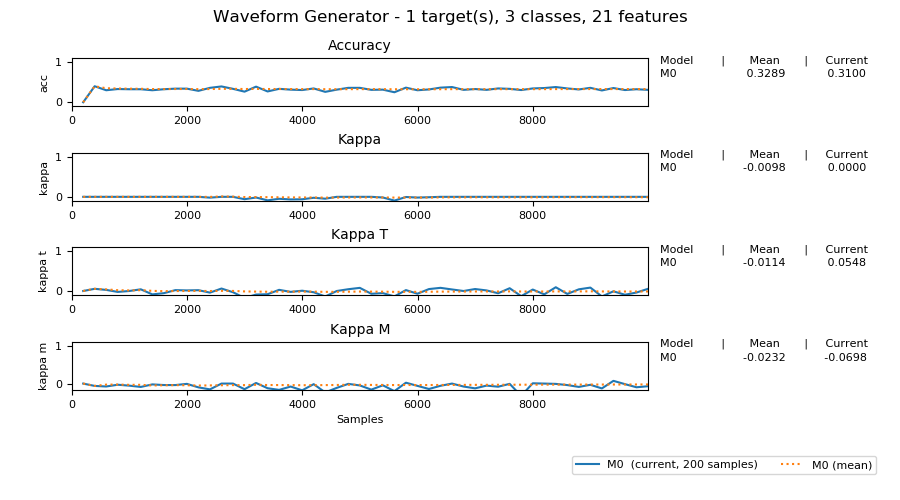

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [9.02s]
Processed samples: 10000
Mean performance:
M0 - Accuracy     : 0.3289
M0 - Kappa        : -0.0098
M0 - Kappa T      : -0.0114
M0 - Kappa M      : -0.0232


In [14]:
prueba_evaluacion_clasificador(MajorityClassClassifier())  

<IPython.core.display.Javascript object>


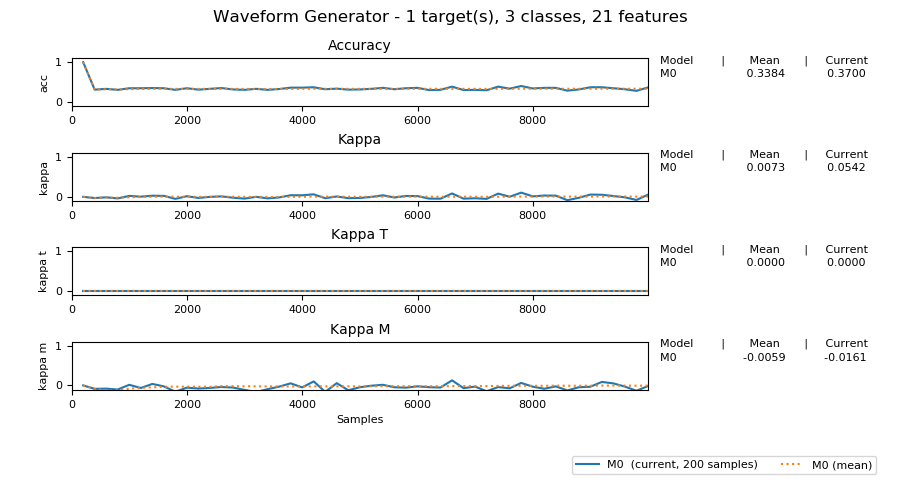

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [9.07s]
Processed samples: 10000
Mean performance:
M0 - Accuracy     : 0.3384
M0 - Kappa        : 0.0073
M0 - Kappa T      : 0.0000
M0 - Kappa M      : -0.0059


In [15]:
prueba_evaluacion_clasificador(MajorityClassClassifier(decay_factor=0.95))  

<IPython.core.display.Javascript object>


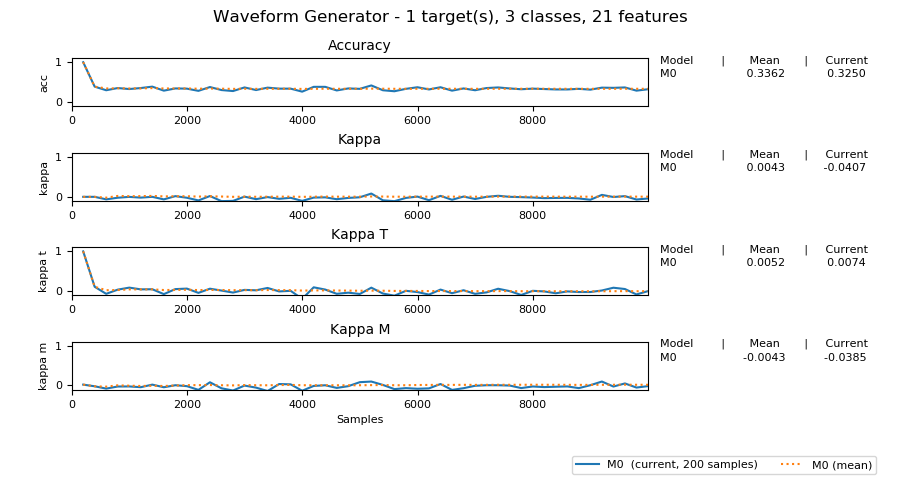

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [9.57s]
Processed samples: 10000
Mean performance:
M0 - Accuracy     : 0.3362
M0 - Kappa        : 0.0043
M0 - Kappa T      : 0.0052
M0 - Kappa M      : -0.0043


In [16]:
prueba_evaluacion_clasificador(MajorityClassClassifier(window_size=100))  

Se pueden incluir a partir aquí pruebas adicionales.

# *--> Clasificador media más cercana*

Se implementa el clasisificador *media más cercana*. Cada clase se resume en una única instancia con el promedio de todas sus instancias. Para clasificar, se calcula la distancia a la instancia promedio de cada clase y se asigna la etiqueta correspondiente a la más cercana.

La clase se llamará `NearestMeanClassifier` y debe heredar de `BaseSKMObject` y `ClassifierMixin`.

In [17]:
# Clase NearestMeanClassifier

import numpy as np

from skmultiflow.utils import get_dimensions  # Utilizado para obtener las dimensiones de un array dentro del 
                                              # código del clasificador.
from skmultiflow.core.base import BaseSKMObject, ClassifierMixin # Superclases de las que heredará el clasificador.


class NearestMeanClassifier(BaseSKMObject, ClassifierMixin):
    """
    Clasificador que predice la clase cuya instancia promedio es la más cercana
    """
    
    def __init__(self):
        super().__init__()  # Para heredar de las superclases.
        self._observed_class_distribution = {}  # Diccionario donde almacenaré los diferentes valores de la clase 
                                                # que van llegando y el número de veces que lo hacen, ponderado 
                                                # con el peso de cada instancia correspondiente, en el caso de 
                                                # que se indiquen dichos pesos.
        self._classes = None  # Para algún método de clasificación puede ser necesario que se le indiquen como 
                              # parámetro las diferentes clases que le van a llegar en las instancias.
        self._suma_valores_atributos = {}  # Diccionario en el que almacenaré la suma de los valores de los 
                                           # atributos de cada una de las instancias con las que voy entrenando 
                                           # el modelo, para cada una de las clases que van apareciendo en el 
                                           # flujo de instancias de entrenamiento. Las claves del diccionario 
                                           # serán cada una de las clases que han aparecido, y los valores serán 
                                           # arrays (vectores) de Numpy de dimensión igual al número de atributos 
                                           # de las instancias del flujo.
        self._coordenadas_instancia_promedio = {}  # Diccionario en el que almacenaré las coordenadas de la 
                                                   # instancia promedio para cada una de las clases que han 
                                                   # aparecido en el flujo de datos de entrenamiento. Las claves 
                                                   # del diccionario serán cada una de las clases que han 
                                                   # aparecido, y los valores serán arrays (vectores) de Numpy de 
                                                   # dimensión igual al número de atributos de las instancias 
                                                   # del flujo.
        
        # NOTA: Los dos atributos anteriores (_suma_valores_atributos, _coordenadas_instancia_promedio), lo mismo 
        # que el atributo _observed_class_distribution, se han calculado para las clases que hasta el momento van 
        # apareciendo en las instancias del flujo de datos de entrenamiento, y no para el máximo número de clases 
        # distintas que sabemos que tiene el flujo, ya que para las clases que aún no han aparecido todavía no 
        # tenemos el modelo entrenado, con lo cual no podemos calcular una instancia promedio para cada una de 
        # esas clases.
    
    def partial_fit(self, X, y, classes=None, sample_weight=None):
        """ Partially (incrementally) fit the model.
        
        Parameters
        ----------
        X : numpy.ndarray of shape (n_samples, n_features)
            The features to train the model.
        
        y: numpy.ndarray of shape (n_samples)
            An array-like with the labels of all samples in X.
        
        classes: numpy.ndarray, optional (default=None)
            Array with all possible/known classes. Usage varies depending on the learning method.
        
        sample_weight: numpy.ndarray of shape (n_samples), optional (default=None)
            Samples weight. If not provided, uniform weights are assumed.
            Usage varies depending on the learning method.
        
        Returns
        -------
        Clasificador media más cercana
            self
        
        """
        if not self._classes and classes is not None:
            self._classes = classes

        if y is not None:
            row_cnt, _ = get_dimensions(X) # Como lo que me interesa es el número de filas de X, podría haber 
                                           # utilizado row_cnt = X.shape[0], o bien row_cnt = len(X)
            if sample_weight is None:
                sample_weight = np.ones(row_cnt)
            if row_cnt != len(sample_weight):
                raise ValueError(
                    'Inconsistent number of instances ({}) and weights ({}).'.format(row_cnt, len(
                        sample_weight)))
            for i in range(row_cnt):
                if sample_weight[i] != 0.0:
                    self._partial_fit(X[i], y[i], sample_weight[i])
        return self
    
    def _partial_fit(self, X, y, weight):  # Utilizo este método privado para entrenar el modelo con 
                                           # muestras que le llegan de una en una.
        """ Trains the model on samples X and corresponding targets y.
        
        Private function where actual training is carried on.
        
        Parameters
        ----------
        X: numpy.ndarray of shape (1, n_features)
            Instance attributes.
        y: int
            Class label for sample X.
        sample_weight: float
            Sample weight.
        
        """
        # Vamos calculando y actualizando los contadores para las clases de las instancias de entrenamiento que 
        # van llegando. Son contadores ponderados, es decir, en el caso de que se indiquen los pesos 
        # correspondientes de cada una de las instancias, los tiene en cuenta para calcular estos contadores.
        # NOTA: En el caso de que no se indiquen pesos de las instancias, estos pesos toman por defecto el 
        # valor 1, con lo cual _observed_class_distribution almacenará los contadores simples de las instancias 
        # pertenecientes a cada una de las clases. 
        # Por lo tanto, tenemos así la suma de pesos de las instancias de entrenamiento para cada una de las 
        # clases que han aparecido hasta el momento en el flujo de datos:
        try:
            self._observed_class_distribution[y] += weight
        except KeyError:
            self._observed_class_distribution[y] = weight
        
        # Calculamos los vectores que contienen la suma de los atributos de las instancias de entrenamiento:
        if y not in self._suma_valores_atributos.keys():
            self._suma_valores_atributos[y] = np.zeros(len(X))  # Inicializamos el vector correspondiente a la 
                                                                # clase 'y' de la instancia de entrenamiento 
                                                                # actual en el caso de que dicha clase sea la 
                                                                # primera vez que aparece en el flujo.
        for i in range(len(X)):
            self._suma_valores_atributos[y][i] += X[i] * weight # Sumo los atributos dentro del vector de la 
                                                                # clase correspondiente 'y', que es la clase 
                                                                # de la instancia de entrenamiento actual. En 
                                                                # el caso de que se proporcionen pesos de cada 
                                                                # una de las instancias, la suma anterior está 
                                                                # ponderada con dichos pesos.
        
        # Calculamos ahora las coordenadas de la instancia promedio para cada una de las clases que hasta el 
        # momento han aparecido en el flujo de datos:
        if y not in self._coordenadas_instancia_promedio.keys():
            self._coordenadas_instancia_promedio[y] = np.zeros(len(X)) # Inicializamos el vector correspondiente 
                                                                       # a la clase 'y' de la instancia de 
                                                                       # entrenamiento actual en el caso de que 
                                                                       # dicha clase sea la primera vez que 
                                                                       # aparece en el flujo.
        for i in range(len(X)):
            self._coordenadas_instancia_promedio[y][i] += self._suma_valores_atributos[y][i] / self._observed_class_distribution[y]
                                                # Las coordenadas de la instancia promedio de cada clase se 
                                                # calculan como los cocientes entre los valores de la suma 
                                                # (ponderada) de cada una de las coordenadas o atributos de cada 
                                                # instancia de entrenamiento para cada clase y la suma (ponderada) 
                                                # de instancias de dicha clase.
        
        # Al final de esta fase de entrenamiento incremental obtenemos el modelo entrenado, es decir, en el que 
        # conocemos las coordenadas o atributos de la instancia promedio de cada una de las clases que hasta el 
        # momento han aparecido con el flujo de datos.
    
    def predict(self, X):
        """ Predict classes for the passed data.
        
        Parameters
        ----------
        X : numpy.ndarray of shape (n_samples, n_features)
            The set of data samples to predict the labels for.
        
        Returns
        -------
        A numpy.ndarray with all the predictions for the samples in X.
        
        """
        # Utilizaremos el concepto de distancia Euclídea para calcular las distancias. Por lo tanto suponemos que 
        # los atributos de las instancias que llegan en el flujo son valores numéricos.
        
        lista_pred = []  # Lista que usaré para almacenar las predicciones de las instancias recibidas.
        distancia = {}  # Diccionario en el que almacenaré las distancias de cada nueva instancia a las instancias 
                        # promedio de cada una de las clases aparecidas hasta el momento en el flujo de datos.
        for i in range(X.shape[0]):
            for key, value in self._coordenadas_instancia_promedio.items():
                aux_suma = 0  # Variable auxiliar usada para calcular la distancia.
                for j in range(X.shape[1]):
                    aux_suma += (value[j] - X[i, j])**2
                distancia[key] = aux_suma**.5
            lista_pred.append(min(distancia.items(), key=lambda x: x[1])[0])  # Almaceno en la lista el valor de 
                                                                              # la clase con distancia promedio 
                                                                              # menor a la instancia recibida.
            distancia.clear()  # Borro todos los registros del diccionario para inicializarlos en la siguiente 
                               # iteración con los de la siguiente instancia de X.
        return np.array(lista_pred)  # Devolvemos un array de Numpy.
    
    def predict_proba(self, X):
        """ Estimates the probability of each sample in X belonging to each of the class-labels.
        
        Parameters
        ----------
        X : Numpy.ndarray of shape (n_samples, n_features)
            The matrix of samples one wants to predict the class probabilities for.
        
        Returns
        -------
        A numpy.ndarray of shape (n_samples, n_labels), in which each outer entry is associated
        with the X entry of the same index. And where the list in index [i] contains
        len(self.target_values) elements, each of which represents the probability that
        the i-th sample of X belongs to a certain class-label.
        
        """
        lista_proba = []  # Lista que usaré para almacenar los arrays con las probabilidades, para cada una de 
                          # las instancias, de cada una de las clases que hasta la fecha han aparecido.
        for i in range(X.shape[0]):
            marcador_auxiliar = 0  # Variable auxiliar que nos permitirá saltar a la siguiente iteración del 
                                   # bucle "for" que recorre el bloque de instancias que llegan, en el 
                                   # improbable caso de que la nueva instancia que llega coincida con una de las 
                                   # instancias promedio de alguna de las clases aparecidas hasta el momento en 
                                   # el flujo de datos de entrenamiento.
            
            # Vamos a necesitar conocer cuál es el máximo número de clases que hasta la fecha son conocidas en 
            # el flujo para calcular la probabilidad de cada una para cada instancia. Ese número de clases será 
            # el máximo valor entre el número de clases observadas hasta el momento y el máximo valor de clase 
            # obtenido hasta la fecha más 1.
            # NOTA: Esto es así porque las clases llegan como valores numéricos consecutivos desde el 0 al que 
            # corresponda.
            # NOTA: Ejemplo: puede pasar que en las instancias que llegan en X las clases que han aparecido sean 
            # solamente 0 y 2. En este caso el máximo número de clases que hasta la fecha han aparecido es dos, 
            # pero como las clases hemos dicho que son valores numéricos consecutivos sabemos que al ser el mayor 
            # valor de clase aparecido el 2, tenemos hasta el momento tres clases (2+1), que son 0, 1, 2.
            
            # NOTA: En el caso de que nos indiquen como parámetro las clases que tiene el flujo de instancias, 
            # el máximo número de clases será la mayor de las instancias más 1, ya que como ya hemos dicho las 
            # clases llegan como valores numéricos consecutivos empezando en 0.
            
            # NOTA IMPORTANTE: Para las probabilidades de las clases que sabemos que existen en el flujo pero que 
            # aún no han aparecido en las instancias de entrenamiento, dejamos a 0 la probabilidad de que la 
            # instancia actual pertenezca a las mismas, ya que no tenemos el modelo entrenado para dichas clases 
            # y por lo tanto no conocemos la instancia promedio de las mismas.
            
            if self._classes is not None:
                lista_proba.append(np.zeros(int(max(self._classes)) + 1))
            else:
                aux = [len(self._observed_class_distribution), max(self._observed_class_distribution.keys()) + 1]
                lista_proba.append(np.zeros(max(aux)))  # Creamos un array cuyo tamaño corresponda al del máximo 
                                                        # número de clases del flujo conocidas hasta la fecha, 
                                                        # para almacenar las probabilidades de las clases para 
                                                        # cada instancia.
            
            # La probabilidad de que una instancia pertenezca a cada una de las clases será proporcional a la 
            # inversa de su distancia a la instancia promedio de cada clase:
            
            # NOTA: Debido a que el método predict_proba puede ser llamado de manera independiente, sin que 
            # previamente se haya llamamo al método predict, lo primero que haremos será calcular las distancias 
            # de las nuevas instancias a las instancias promedio de cada clase (por esta razón no almacenamos las 
            # distancias al ejecutar el método predict):
            
            distancia = {}  # Diccionario en el que almacenaré las distancias de cada nueva instancia a las 
                            # instancias promedio de cada una de las clases aparecidas hasta el momento en el 
                            # flujo de datos de entrenamiento.
            for key, value in self._coordenadas_instancia_promedio.items():
                aux_suma = 0  # Variable auxiliar usada para calcular la distancia.
                for j in range(X.shape[1]):
                    aux_suma += (value[j] - X[i, j])**2
                distancia[key] = aux_suma**.5
                
                # Para el improbable caso en que la nueva instancia que llega coincida con una de las instancias 
                # promedio de alguna de las clases:
                if distancia[key] == 0.0:
                    lista_proba[i][int(key)] = 1.0  # La probabilidad será 1 para la clase con cuya instancia 
                                                    # promedio coincide y 0 para el resto de clases.
                    marcador_auxiliar = 1
                    break  # Salimos del bucle "for" que calcula las distancias para cada nueva instancia.
            if marcador_auxiliar == 1:
                distancia.clear()  # Borro todos los registros del diccionario para inicializarlos en la siguiente 
                                   # iteración con los de la siguiente instancia de X.
                continue  # Salimos de la actual iteración del bucle "for" que recorre el bloque de instancias 
                          # que llegan, y continuamos con la siguiente instancia del bloque.
            
            # Para el cálculo de las probabilidades de una instancia a las instancias promedio de cada una de las 
            # clases, tenemos que el denominador de la expresión es el mismo para todas las clases:
            denominador_prob = 0
            for value in distancia.values():
                denominador_prob += 1/value
            
            # Calculo por último las probabilidades, dejando a 0 las probabilidades de posibles clases que aún 
            # sabiendo que existen, no han aparecido aún en el flujo de instancias de entrenamiento, como ya hemos 
            # comentado anteriormente:
            for key, value in distancia.items():
                lista_proba[i][int(key)] = (1/value) / denominador_prob
            
            distancia.clear()  # Borro todos los registros del diccionario para inicializarlos en la siguiente 
                               # iteración con los de la siguiente instancia de X.
        return np.array(lista_proba)  # Devolvemos un array de Numpy.


### Pruebas de `NearestMeanClassifier`

In [18]:
prueba_clasificador(NearestMeanClassifier()) 

Etiquetas: [1 1 1 0 1 0 1 1 2 0]
Predicciones en bloque: [0 1 1 1 1 0 1 1 1 0] [2 2 2 2 2 2 2 2 2 2] 
 [[0.28445952 0.09824295 0.61729753]
 [0.25706089 0.0986104  0.64432871]
 [0.3129036  0.10786989 0.57922652]
 [0.37947269 0.11512262 0.50540469]
 [0.21075941 0.07854492 0.71069567]
 [0.25775857 0.0900581  0.65218333]
 [0.2614103  0.09850591 0.6400838 ]
 [0.34365409 0.11738836 0.53895755]
 [0.23422753 0.08673259 0.67903988]
 [0.30496158 0.10147606 0.59356236]]
Predicciones una a una:
[1] [2] [[0.24644363 0.09245949 0.66109688]]
[0] [2] [[0.31549012 0.09402689 0.59048299]]
[0] [2] [[0.24672508 0.09933844 0.65393647]]
[1] [2] [[0.16122843 0.08629453 0.75247704]]
[0] [2] [[0.20777878 0.09680224 0.69541898]]
[2] [2] [[0.11486682 0.06631569 0.81881749]]
[0] [2] [[0.26380422 0.15468405 0.58151173]]
[2] [2] [[0.19023007 0.129618   0.68015193]]
[1] [2] [[0.24649736 0.17327448 0.58022816]]
[1] [2] [[0.26400857 0.16189881 0.57409262]]


<IPython.core.display.Javascript object>


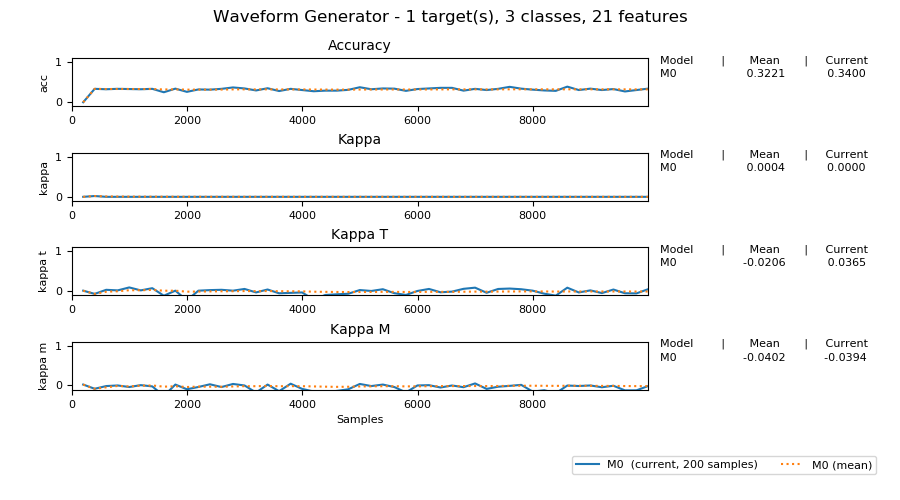

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [11.07s]
Processed samples: 10000
Mean performance:
M0 - Accuracy     : 0.3221
M0 - Kappa        : 0.0004
M0 - Kappa T      : -0.0206
M0 - Kappa M      : -0.0402


In [19]:
prueba_evaluacion_clasificador(NearestMeanClassifier())  

Se pueden incluir a partir aquí pruebas adicionales.